# All modules

### This notebook computes all modules needed for the shear Correlation Function $\xi_{+}, \xi_{-}$

In [1]:
import numpy as np
print(np.__version__) # version 1.20.0 or higher it's needed in order to compute all c_m correctly (np.fft)
import scipy as sp
import matplotlib.pyplot as plt
import math
import time

1.21.2


In [2]:
# Specifying input parameters

OmegaM_in=0.3
# h_in=0.7
H0_in=1/2997.92458 # hubble constant (t_0) in units of h/Mpc
zTableChi_in = np.linspace(0, 20, num=201)
zTableChi_in

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

### Module background Cosmology

Outputs:


chiOfzT_backg

zOfchiT_backg

aOfchiT_backg

**Comoving radial distance chi:  $\chi(z)$**
$$
    \chi(z) = \int_0^z \frac{1}{H(z')}dz'. 
$$
 

**Friedmann equation in terms of z & $\Omega_A$:**
$$
    H(z) = H_0 \sqrt{\Omega_M (1+z)^3 + (1-\Omega_M)},
$$
with  $\Omega_r+\Omega_M+\Omega_k+\Omega_\Lambda =1$,  $\Omega_K=\Omega_r=0$.

In [3]:
OmegaM = OmegaM_in
H0=H0_in

**Get Table chi(z)T**

In [4]:
# THIS CELL IS THE NEW MODIFICATION: INTEGRATION BY TRAPEZE

def integrand(z): # i.e., 1/H(z')
    return 1/(H0*np.sqrt(OmegaM*(1+z)**3 + (1-OmegaM)))

zT = zTableChi_in

delta_z = zT[1] - zT[0]
Nz = len(zT)

start_time = time.time()

chiT_x = np.zeros(Nz)
chiT_y = np.zeros(Nz)

xp = xA = xB = 0.0

z = zT[0]
xA = integrand(z)
chiT_x[0], chiT_y[0] = z, xA*delta_z
z_prev = z

for i in range(1,Nz):
    z = zT[i]
    xB = integrand(z)
    xp = xp + 0.5*(xA + xB)*delta_z
    chiT_x[i], chiT_y[i] = z, xp
    xA = xB
    z_prev = z

end_time = time.time()
print('Time:', end_time - start_time, 's.')

# so, in direct integration code, chiT_x = zT, chiT_y = chi_y
chiT = np.concatenate((chiT_x.reshape(-1,1), chiT_y.reshape(-1,1)), axis = 1)

from scipy.interpolate import CubicSpline
chi = CubicSpline(chiT_x, chiT_y)
chi_inter_new = chi(chiT_x)

Time: 0.0013849735260009766 s.


In [5]:
from scipy.integrate import quad
from functools import partial

def H(OmegaM, z):
    return 1/(H0*np.sqrt(OmegaM*(1+z)**3 + (1-OmegaM))) # Friedmann eq. in z, as the expr H

def chi_function(z, OmegaM):
    result = np.array(list(map(partial(quad, partial(H, OmegaM), 0), z)))[:,0] # integrating H(z) from 0 to z
    return result

In [6]:
zT = zTableChi_in
zMax = zT[-1]

# runtime count ("parallel" table)
start = time.time()

chi_y = chi_function(zT, OmegaM)

print("The time used to execute this (in seconds) is showed below: ")
end = time.time()

print(end - start)

The time used to execute this (in seconds) is showed below: 
0.02585911750793457


In [7]:
# array of lists, with all the i values of zT and the i values of the integrated chi(z) 

chiOfz_T = np.concatenate((zT.reshape(-1,1),chi_y.reshape(-1,1)), axis = 1)
chiOfz_T

array([[0.00000000e+00, 0.00000000e+00],
       [1.00000000e-01, 2.92918141e+02],
       [2.00000000e-01, 5.71706267e+02],
       [3.00000000e-01, 8.36077809e+02],
       [4.00000000e-01, 1.08608234e+03],
       [5.00000000e-01, 1.32203778e+03],
       [6.00000000e-01, 1.54445940e+03],
       [7.00000000e-01, 1.75399471e+03],
       [8.00000000e-01, 1.95136896e+03],
       [9.00000000e-01, 2.13734262e+03],
       [1.00000000e+00, 2.31268016e+03],
       [1.10000000e+00, 2.47812830e+03],
       [1.20000000e+00, 2.63440195e+03],
       [1.30000000e+00, 2.78217580e+03],
       [1.40000000e+00, 2.92208005e+03],
       [1.50000000e+00, 3.05469904e+03],
       [1.60000000e+00, 3.18057170e+03],
       [1.70000000e+00, 3.30019333e+03],
       [1.80000000e+00, 3.41401798e+03],
       [1.90000000e+00, 3.52246130e+03],
       [2.00000000e+00, 3.62590345e+03],
       [2.10000000e+00, 3.72469208e+03],
       [2.20000000e+00, 3.81914510e+03],
       [2.30000000e+00, 3.90955344e+03],
       [2.400000

In [8]:
chiOfz_T - chiT

array([[ 0.00000000e+00, -2.99792458e+02],
       [ 0.00000000e+00,  5.59693160e-02],
       [ 0.00000000e+00,  7.94055028e-02],
       [ 0.00000000e+00,  7.46931492e-02],
       [ 0.00000000e+00,  4.75966593e-02],
       [ 0.00000000e+00,  4.10975084e-03],
       [ 0.00000000e+00, -5.03044740e-02],
       [ 0.00000000e+00, -1.11095563e-01],
       [ 0.00000000e+00, -1.74727225e-01],
       [ 0.00000000e+00, -2.38609703e-01],
       [ 0.00000000e+00, -3.00952505e-01],
       [ 0.00000000e+00, -3.60596078e-01],
       [ 0.00000000e+00, -4.16854411e-01],
       [ 0.00000000e+00, -4.69382392e-01],
       [ 0.00000000e+00, -5.18071022e-01],
       [ 0.00000000e+00, -5.62968299e-01],
       [ 0.00000000e+00, -6.04221501e-01],
       [ 0.00000000e+00, -6.42036258e-01],
       [ 0.00000000e+00, -6.76648293e-01],
       [ 0.00000000e+00, -7.08304431e-01],
       [ 0.00000000e+00, -7.37250244e-01],
       [ 0.00000000e+00, -7.63722346e-01],
       [ 0.00000000e+00, -7.87943908e-01],
       [ 0.

In [9]:
chi_Max = (chiOfz_T[-1])[1] # gives the i,j element of the array
            # (in this case, the element of the last row and last column, which is always the second column in the matrix)
chi_min = (chiOfz_T[0])[1]

print(len(chiOfz_T), "chi z values from chi_min=chi(z=",zT[0], ") =", chi_min, " Mpc/h to chi_Max=chi(z=", zT[-1], ") =",chi_Max, "Mpc/h")

201 chi z values from chi_min=chi(z= 0.0 ) = 0.0  Mpc/h to chi_Max=chi(z= 20.0 ) = 7519.607566466258 Mpc/h


In [10]:
#from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline

chiOfz = CubicSpline(zT,chi_y) # interpolation of chiOfz_T 
#(but instead of using attribute ".interpolate" on chiOfz_T, each coulmn is used)

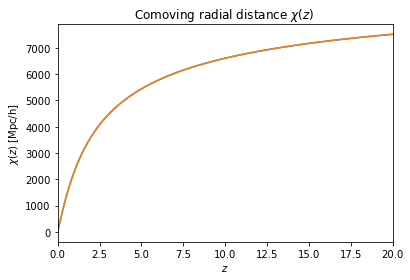

In [11]:
chi_inter = chiOfz(zT) #use interpolated function returned by "CubicSpline"

plt.plot(zT,chi_inter, "-")
plt.plot(chiT_x,chi_inter_new, "-")
plt.title(r'Comoving radial distance $\chi(z)$ ')
plt.xlabel(r"$z$")
plt.ylabel(r"$\chi(z)$ [Mpc/h]")

plt.xlim(0, zMax)

plt.show()

### Compute the inverse   $z(\chi)$, and the scale factor $a(\chi)=\frac{1}{1+z(\chi)}$

In [12]:
# array of lists, with all the i values of y and zT, respectively

zOfchi_T = np.concatenate((chi_y.reshape(-1,1),zT.reshape(-1,1)), axis = 1)
zOfchi_T # inverse of chi(z)

array([[0.00000000e+00, 0.00000000e+00],
       [2.92918141e+02, 1.00000000e-01],
       [5.71706267e+02, 2.00000000e-01],
       [8.36077809e+02, 3.00000000e-01],
       [1.08608234e+03, 4.00000000e-01],
       [1.32203778e+03, 5.00000000e-01],
       [1.54445940e+03, 6.00000000e-01],
       [1.75399471e+03, 7.00000000e-01],
       [1.95136896e+03, 8.00000000e-01],
       [2.13734262e+03, 9.00000000e-01],
       [2.31268016e+03, 1.00000000e+00],
       [2.47812830e+03, 1.10000000e+00],
       [2.63440195e+03, 1.20000000e+00],
       [2.78217580e+03, 1.30000000e+00],
       [2.92208005e+03, 1.40000000e+00],
       [3.05469904e+03, 1.50000000e+00],
       [3.18057170e+03, 1.60000000e+00],
       [3.30019333e+03, 1.70000000e+00],
       [3.41401798e+03, 1.80000000e+00],
       [3.52246130e+03, 1.90000000e+00],
       [3.62590345e+03, 2.00000000e+00],
       [3.72469208e+03, 2.10000000e+00],
       [3.81914510e+03, 2.20000000e+00],
       [3.90955344e+03, 2.30000000e+00],
       [3.996183

In [13]:
zOfchi = CubicSpline(chi_y,zT)
z_interp = zOfchi(chi_y) #use interpolated function returned by "interp1d" again

In [14]:
# table with a column for the x values of zOfchi and another with 1/(1+zT), the new values of "y"
aOfchi_y = 1/(1+zT)

aOfchi_T = np.concatenate((chi_y.reshape(-1,1),aOfchi_y.reshape(-1,1)), axis = 1)
aOfchi_T

array([[0.00000000e+00, 1.00000000e+00],
       [2.92918141e+02, 9.09090909e-01],
       [5.71706267e+02, 8.33333333e-01],
       [8.36077809e+02, 7.69230769e-01],
       [1.08608234e+03, 7.14285714e-01],
       [1.32203778e+03, 6.66666667e-01],
       [1.54445940e+03, 6.25000000e-01],
       [1.75399471e+03, 5.88235294e-01],
       [1.95136896e+03, 5.55555556e-01],
       [2.13734262e+03, 5.26315789e-01],
       [2.31268016e+03, 5.00000000e-01],
       [2.47812830e+03, 4.76190476e-01],
       [2.63440195e+03, 4.54545455e-01],
       [2.78217580e+03, 4.34782609e-01],
       [2.92208005e+03, 4.16666667e-01],
       [3.05469904e+03, 4.00000000e-01],
       [3.18057170e+03, 3.84615385e-01],
       [3.30019333e+03, 3.70370370e-01],
       [3.41401798e+03, 3.57142857e-01],
       [3.52246130e+03, 3.44827586e-01],
       [3.62590345e+03, 3.33333333e-01],
       [3.72469208e+03, 3.22580645e-01],
       [3.81914510e+03, 3.12500000e-01],
       [3.90955344e+03, 3.03030303e-01],
       [3.996183

In [15]:
aOfchi = CubicSpline(chi_y,aOfchi_y) #scale factor function a(chi) given by the interpolation

a_chi = aOfchi(chi_y) #use interpolated function returned by "interp1d" again

In [16]:
chi_Maxvalue=np.where(chi_y == chi_Max)[0][0]
chi_minvalue=np.where(chi_y == chi_min)[0][0]

In [17]:
a_min = a_chi[chi_Maxvalue] # i.e., the value with chi_Max= 7519.607 corresponds to the position 200
a_Max = a_chi[chi_minvalue] # i.e., the value with chi_min= 0 corresponds to the position 0

print("aOfchi: a(chi) function: ")
print("a_min = ", a_min, " a_Max = ", a_Max)

aOfchi: a(chi) function: 
a_min =  0.047619047619047616  a_Max =  1.0


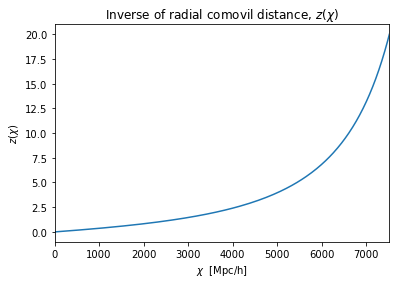

In [18]:
plt.plot(chi_y,z_interp, "-")
plt.title(r'Inverse of radial comovil distance, $z(\chi)$ ')
plt.xlabel(r"$\chi$  [Mpc/h]")
plt.ylabel(r"$z(\chi)$")

plt.xlim(0, chi_Max)

plt.show()

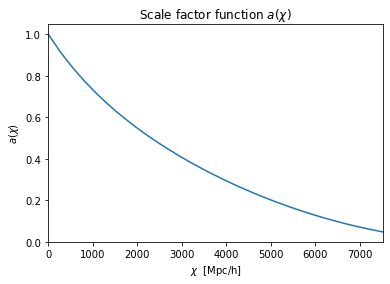

In [19]:
plt.plot(chi_y,a_chi, "-")
plt.title(r'Scale factor function $a(\chi)$ ')
plt.xlabel(r"$\chi$  [Mpc/h]")
plt.ylabel(r"$a(\chi)$")

plt.xlim(0, chi_Max)

plt.show()

In [20]:
# OUTPUTS

chiOfzT_backg = chiOfz_T
zOfchiT_backg = zOfchi_T
aOfchiT_backg = aOfchi_T

# Module of Linear Growth

### Outputs:

DplusOfchi_linG

DplusOfa_linG

#### Obtain the linear growth function $D_+$ as a function of "$a$" and "$\chi$"

#### $D_+$ is the fastest growing solution to the equation

$$
    \frac{d^2D}{dt^2} + 2H \frac{dD}{dt} - \frac{3}{2} \Omega_M(a) H^2 D = 0.
$$
 
 But we use **eta = ln(a)** instead of cosmic time t, hence we solve the equation
 
 $$
     D''[\eta] + \left( 2 - \frac{3}{2 (1+\frac{(1-\Omega_M)}{\Omega_M} e^{3\eta})} \right)  D'[\eta] - \frac{3}{2 (1+\frac{(1-\Omega_M)}{\Omega_M} e^{3\eta})} D[\eta]= 0,
 $$
 
 with proper initial conditions, which are $EdS$ at early times $D(a)=a$. Hence $D[\eta_{ini}] = e^{\eta_{ini}}$ and $D'[\eta_{ini}]=e^{\eta_{ini}}$.
 
In our convention, $D[today] =1$.

In [21]:
eta_ini = -8
eta_fin = 0 # notice today a=1, eta=0
Dplus_i = math.exp(eta_ini) # initial condition
dDplus_i = math.exp(eta_ini) # initial condition

Om_M = OmegaM_in # just to simplify writting

### Solving differential equation system in Dp(eta)

Convertig a **2nd order ODE** into a **pair** of **1st order ODE** with $Dp"=(Dp')'\equiv x'$, i.e., $x \equiv Dp'$, we have now the system

$$
   Dp' = x,
$$

$$
    x'[\eta] + f1[\eta] x[\eta]-f2[\eta] Dp[\eta]=0,
$$

where, besides,

$$
    Dp'[\eta_{ini}] \equiv \frac{dDp[\eta_{ini}]}{d\eta},
$$
$$
    Dp[\eta_{ini}] \equiv Dp_{ini}.
$$

S is a function of (x,eta) and represents the second order derivative as a function of the first derivative Dp'=x and the original function Dp.

In [22]:
# defining functions f1 and f2(eta)
def f1(eta):
    return 2.0-3.0/(2.0*(1.0+((1.0-Om_M)/Om_M)*math.exp(3.0*eta)))

def f2 (eta):
    return 3.0/(2.0*(1.0+((1.0-Om_M)/Om_M)*math.exp(3.0*eta)))

$$
     D''[\eta] + \left( 2 - \frac{3}{2 (1+\frac{(1-\Omega_M)}{\Omega_M} e^{3\eta})} \right)  D'[\eta] - \frac{3}{2 (1+\frac{(1-\Omega_M)}{\Omega_M} e^{3\eta})} D[\eta]= 0,
$$


$$
    \Rightarrow D''[\eta] + f_1 D'[\eta] - f_2 D[\eta] = 0.
$$


$$
    \therefore \ \mbox{ (EDO)    } \ \boxed{ D''[\eta] = - f_1 D'[\eta] + f_2 D[\eta]}
$$

In [23]:
from scipy.integrate import odeint  # ***** Tratar de buscar mejor método de resolución de ED

def S(x,eta):
    return [x[1],-f1(eta)*x[1]+f2(eta)*x[0]]

In [24]:
eta_T = np.linspace(-8.0,0,81, endpoint = True)
#print(eta_T[-1])
Dplus_sol, dDplus_sol = odeint(S, [Dplus_i, dDplus_i], eta_T).T
Dplus_sol         # eje x de DplusOfaT Math   # 4ta cifra 

array([3.35462628e-04, 3.70754517e-04, 4.09753949e-04, 4.52838435e-04,
       5.00467705e-04, 5.53106351e-04, 6.11282077e-04, 6.75574875e-04,
       7.46625007e-04, 8.25146890e-04, 9.11927197e-04, 1.00783673e-03,
       1.11383461e-03, 1.23097994e-03, 1.36044470e-03, 1.50352806e-03,
       1.66165713e-03, 1.83641897e-03, 2.02955736e-03, 2.24300444e-03,
       2.47890092e-03, 2.73961059e-03, 3.02774060e-03, 3.34617277e-03,
       3.69809700e-03, 4.08703020e-03, 4.51687077e-03, 4.99191550e-03,
       5.51692431e-03, 6.09714702e-03, 6.73839371e-03, 7.44708163e-03,
       8.23030097e-03, 9.09589663e-03, 1.00525190e-02, 1.11097512e-02,
       1.22781741e-02, 1.35694819e-02, 1.49965954e-02, 1.65737967e-02,
       1.83168716e-02, 2.02432591e-02, 2.23722420e-02, 2.47251140e-02,
       2.73254263e-02, 3.01991759e-02, 3.33751156e-02, 3.68850093e-02,
       4.07639393e-02, 4.50506726e-02, 4.97880229e-02, 5.50232705e-02,
       6.08086215e-02, 6.72016824e-02, 7.42660032e-02, 8.20716434e-02,
      

In [25]:
eta_ini_T = eta_ini

#array of chi(z) values
x_Dplus_a = np.exp(eta_T)
y_Dplus_a = Dplus_sol/Dplus_sol[-1]
#  corresponds to the entries x & y of the new array DplusOfa_T 
y_Dplus_a  # eje y de DplusOfaT Math   # 4ta cifra

array([4.30612231e-04, 4.75914204e-04, 5.25975317e-04, 5.81280156e-04,
       6.42418848e-04, 7.09987760e-04, 7.84664273e-04, 8.67192884e-04,
       9.58395461e-04, 1.05918905e-03, 1.17058346e-03, 1.29369648e-03,
       1.42975929e-03, 1.58013135e-03, 1.74631711e-03, 1.92998421e-03,
       2.13296453e-03, 2.35729529e-03, 2.60521486e-03, 2.87920342e-03,
       3.18200886e-03, 3.51666543e-03, 3.88651977e-03, 4.29527107e-03,
       4.74701403e-03, 5.24626306e-03, 5.79802230e-03, 6.40780728e-03,
       7.08172800e-03, 7.82652332e-03, 8.64965128e-03, 9.55934930e-03,
       1.05647186e-02, 1.16758292e-02, 1.29037850e-02, 1.42608874e-02,
       1.57607182e-02, 1.74182886e-02, 1.92501843e-02, 2.12747382e-02,
       2.35122136e-02, 2.59849957e-02, 2.87178370e-02, 3.17380704e-02,
       3.50759273e-02, 3.87647786e-02, 4.28415322e-02, 4.73469615e-02,
       5.23260995e-02, 5.78287088e-02, 6.39097468e-02, 7.06299042e-02,
       7.80561946e-02, 8.62625639e-02, 9.53305872e-02, 1.05350196e-01,
      

In [26]:
# Interpolation of the "table" DplusOfa_T (not needed to define)
#with columns x and y_Dplus_a

DplusOfa = CubicSpline(x_Dplus_a,y_Dplus_a, extrapolate=True)
a = np.linspace(0.005,1,1000, endpoint = True)

DplusOfa_interp = DplusOfa(a)
DplusOfa_interp

array([0.0064186 , 0.00769719, 0.00897578, 0.01025437, 0.01153296,
       0.01281154, 0.01409013, 0.01536871, 0.01664729, 0.01792588,
       0.01920446, 0.02048304, 0.02176162, 0.0230402 , 0.02431878,
       0.02559735, 0.02687592, 0.02815449, 0.02943306, 0.03071162,
       0.03199018, 0.03326874, 0.03454729, 0.03582584, 0.03710438,
       0.03838291, 0.03966144, 0.04093996, 0.04221847, 0.04349698,
       0.04477548, 0.04605398, 0.04733246, 0.04861094, 0.04988941,
       0.05116786, 0.05244631, 0.05372475, 0.05500317, 0.05628158,
       0.05755999, 0.05883837, 0.06011675, 0.06139511, 0.06267345,
       0.06395178, 0.0652301 , 0.06650839, 0.06778667, 0.06906493,
       0.07034317, 0.0716214 , 0.0728996 , 0.07417778, 0.07545594,
       0.07673408, 0.0780122 , 0.07929029, 0.08056835, 0.08184639,
       0.08312441, 0.0844024 , 0.08568035, 0.08695828, 0.08823618,
       0.08951405, 0.09079189, 0.0920697 , 0.09334747, 0.09462521,
       0.09590291, 0.09718058, 0.09845821, 0.0997358 , 0.10101

### Make table for $D_+(\chi)$ output

In [27]:
# Table D+(chi) = D+(a(chi))
chi_T = chi_y # not needed to concatenate bc the desired values are just the columns (not a matrix)

### Plots of the growth function $D_+$ as a function of $a$ and a function of $\chi$

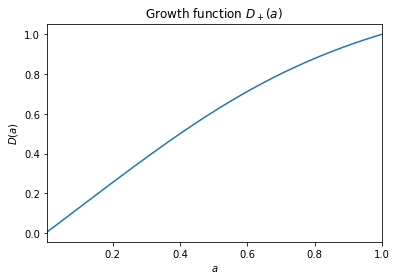

In [28]:
plt.plot(a ,DplusOfa_interp, "-")
plt.title(r'Growth function $D_+(a)$ ')
plt.xlabel(r"$a$ ")
plt.ylabel(r"$D(a)$")

plt.xlim(0.005, 1)

plt.show()

In [29]:
DplusOfchi = CubicSpline(chi_y, DplusOfa(a_chi), extrapolate= True)
DplusOfchi(chi_y)

array([1.        , 0.94966273, 0.90154335, 0.85599254, 0.81318864,
       0.77318116, 0.73592401, 0.70131168, 0.6691991 , 0.63942099,
       0.61180574, 0.5861814 , 0.56238352, 0.5402563 , 0.51965546,
       0.50044823, 0.48251329, 0.46574063, 0.45003043, 0.43529258,
       0.4214457 , 0.40841631, 0.39613813, 0.38455128, 0.37360165,
       0.36324028, 0.35342281, 0.34410901, 0.33526235, 0.32684958,
       0.31884043, 0.31120728, 0.30392489, 0.29697014, 0.29032187,
       0.28396064, 0.27786861, 0.2720293 , 0.26642757, 0.26104942,
       0.25588191, 0.25091307, 0.24613179, 0.24152778, 0.23709146,
       0.23281394, 0.22868692, 0.22470267, 0.22085397, 0.21713408,
       0.21353668, 0.21005588, 0.20668614, 0.20342226, 0.20025936,
       0.19719285, 0.19421843, 0.19133203, 0.18852982, 0.18580819,
       0.18316373, 0.18059322, 0.17809361, 0.17566203, 0.17329574,
       0.17099217, 0.16874886, 0.16656348, 0.16443383, 0.16235782,
       0.16033344, 0.1583588 , 0.15643209, 0.1545516 , 0.15271

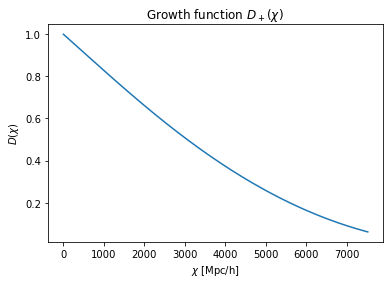

In [30]:
chi_plot = np.linspace(0, chi_T[-1], 1000, endpoint =True)

lin_G = DplusOfchi(chi_plot)

plt.plot( chi_plot,lin_G, "-")
plt.title(r'Growth function $D_+(\chi)$ ')
plt.xlabel(r"$\chi$ [Mpc/h]")
plt.ylabel(r"$D(\chi)$")

plt.show()

In [31]:
# Store variables

DplusOfchi_linG = DplusOfchi
DplusOfa_linG = DplusOfa

## Module of lens efficiency

Inputs:

W_input

Is the **probability distribution of galaxies** $W(\chi)$ in some bin (that is, in some photo-z ). It's a function of the comoving distance, that one usually gets from the survey or some analitical fitting; for example, the *golden* is quite used in *LSST*, a Dirac Delta function is widely used when comparing to simulations.

Sometimes one have the number density of objects $n(\chi)$ instead of $W(\chi)$. In that case, one obtains the latter by  normalizing to unity the former , that is

$$
    N_A = \int_0^\infty n_A(\chi') d\chi,
$$

the total number of galaxies in the photo-z where $n_A(\chi')$ is the **number density of galaxies** in the photo-z *A* (let's call it *A*), then, the functions $W(\chi)$ is

$$
    W_A(\chi)= \frac{1}{N_A} n_A(\chi),
$$

the probability distribution of galaxies at photo-z A. Obviously, by construction it is normalized to unity

$$
    \int_0^\infty W_A(\chi') d\chi' = 1.
$$

### Outputs

*qT_LensEff* (function of the comoving distance $\chi$)

*chimax_LensEff* ($\chi_{max}$ from which one can neglect the lens efficiency, that is $q(\chi >\chi_{max}) = 0$)

*chiBin_LensEff*

The **lens efficiency** is

$$
    q(\chi) = \frac{3H_0^2 \Omega_m}{2c^2} \frac{\chi}{a(\chi)} g_L(\chi),
$$
with $g_L(\chi) = \int_0^\infty \frac{\chi'-\chi}{\chi'} W(\chi')d\chi'$ (sometimes also called *lens efficiency* as $q$).

From it, one can compute the **projected convergence** (or mean convergence)

$$
    \kappa (\mathbf{\theta}) = \int_0^\infty d\chi q(\chi) \delta(\chi \mathbf{\theta},\chi).
$$

The convergence becomes a linear measure of the total matter density, projected along the lone of sight and weighted by the source galaxy distribution.

## $q(\chi)$ lens efficiency: with $W(\chi) = \delta_D (\chi_S-\chi)$

In some applications one can **approximate** the source galaxy distribution with a Dirac Delta distribution as a function of comoving radial distance $\chi_S$. 

In this case, $q(\chi)$ has an analytical solution:

$$
   q(\chi) = \frac{3H_0^2 \Omega_m}{2c^2} \frac{\chi}{a(\chi)} \frac{\chi_S- \chi}{\chi_S} \Theta[\chi_S- \chi],
$$

for $W(\chi) = \delta_D(\chi_S- \chi)$, with $\Theta[\chi_S- \chi]$ the Heaviside function.

**Example:**

In [32]:
# using the interpolated function of the table chiOfz and aOfchi

chiOfz = CubicSpline(zT,chi_y) # interp. of chiOfzT_back

aOfchi = CubicSpline(chi_y,aOfchi_y)

In [33]:
zBin = 1.0
chiBin = chiOfz(zBin)
def gLDiracDelta(chi):
    return (1-chi/chiBin)*np.heaviside(chiBin-chi,0) # definition of the heaviside step function,
                                                     # whichs takes 0 when chiBin - chi <= 0 and 1 in any other case.

In [34]:
def qDiracDelta(chi):
    return 3/2*(H0**2 *Om_M)*(chi/aOfchi(chi))*gLDiracDelta(chi)

In [35]:
def qDiracDelta_over_chi(chi):
    return qDiracDelta(chi)/chi

chi_plot2 = np.linspace(0.01, 5000, 50000, endpoint =True)   # table with range from 0.01 to 5000

qDD_over_chi = qDiracDelta_over_chi(chi_plot2)

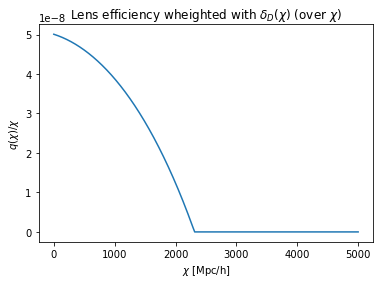

In [36]:
plt.plot(chi_plot2, qDD_over_chi)

plt.title(r'Lens efficiency wheighted with $\delta_D(\chi)$ (over $\chi$)')
plt.ylabel(r"$q(\chi)/ \chi$")
plt.xlabel(r"$\chi$ [Mpc/h]")

plt.show()

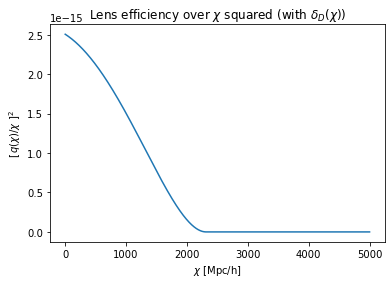

In [37]:
q_ovChi_sqrd = qDD_over_chi*qDD_over_chi

plt.plot(chi_plot2, q_ovChi_sqrd)

plt.title(r'Lens efficiency over $\chi$ squared (with $\delta_D(\chi)$)')
plt.ylabel(r"$ [\, q(\chi)/ \chi \ ]^2$")
plt.xlabel(r"$\chi$ [Mpc/h]")

plt.show()

NOTE: Notice the **Lens Efficiency** is 0 (or almost 0 for $\chi$ much grater than $\chi_s=\chi(z_{bin}$)), hence it has no sense to obtain the functions from the previous modules (e.g., DplusOfChi_linG) for $\chi \gg \chi_s$. For example, above we are computing up to $\chi = 7500$ Mpc/h, which comes from having chosen zTforchi_input up to $z=20$, which is completely unnecessary if $zbin=1$. For this reason, the final code should know first what is the distribution $W$, and from it choose the zTforchi_input table.

In [38]:
chimax = 3000

## $q(\chi)$ lens efficiency: with $W(\chi) = $ (of own choice)


(In the final code one has to choose first the distribution $W(\chi)$ and then compute the lens efficiency)

In [39]:
def q(chi): # IN THIS CASE THE SAME DD IS CHOSEN BUT THE PORPOSE IS TO TAKE A DIFFERENT ONE LATER
    return qDiracDelta(chi) # here this definition would change for a diff. W

chimax_lensEff = chimax
chiBin_lensEff = chiBin
sizeOfchiT = 100

# making table of (i)*chimax/(sizeOfchiT-1) from 1 to the size 100
chiT = np.zeros(100) #defining empty table
for i in range(sizeOfchiT):
    chiT[i] = (i)*chimax/(sizeOfchiT-1) # filling with the values described
chiT

array([   0.        ,   30.3030303 ,   60.60606061,   90.90909091,
        121.21212121,  151.51515152,  181.81818182,  212.12121212,
        242.42424242,  272.72727273,  303.03030303,  333.33333333,
        363.63636364,  393.93939394,  424.24242424,  454.54545455,
        484.84848485,  515.15151515,  545.45454545,  575.75757576,
        606.06060606,  636.36363636,  666.66666667,  696.96969697,
        727.27272727,  757.57575758,  787.87878788,  818.18181818,
        848.48484848,  878.78787879,  909.09090909,  939.39393939,
        969.6969697 , 1000.        , 1030.3030303 , 1060.60606061,
       1090.90909091, 1121.21212121, 1151.51515152, 1181.81818182,
       1212.12121212, 1242.42424242, 1272.72727273, 1303.03030303,
       1333.33333333, 1363.63636364, 1393.93939394, 1424.24242424,
       1454.54545455, 1484.84848485, 1515.15151515, 1545.45454545,
       1575.75757576, 1606.06060606, 1636.36363636, 1666.66666667,
       1696.96969697, 1727.27272727, 1757.57575758, 1787.87878

(Personal note -professor-: The chiT is for the **output** of this module. Not sure how much points are necessary for having good approximations in the final convergence PS. It's believed much less points suffice. **Check**!!!) ***

### Computing the output of the module *chimaxinqT_lensEff*

In [40]:
print(len(chiT))

qT = np.zeros(100)
for i in range(len(chiT)):
    qT[i]= q(chiT[i])
qT

100


array([ 0.00000000e+00,  1.51251957e-06,  3.01492785e-06,  4.50624001e-06,
        5.98545900e-06,  7.45157615e-06,  8.90357168e-06,  1.03404153e-05,
        1.17610665e-05,  1.31644754e-05,  1.45495830e-05,  1.59153218e-05,
        1.72606162e-05,  1.85843829e-05,  1.98855314e-05,  2.11629641e-05,
        2.24155772e-05,  2.36422604e-05,  2.48418973e-05,  2.60133659e-05,
        2.71555310e-05,  2.82672292e-05,  2.93472827e-05,  3.03945019e-05,
        3.14076856e-05,  3.23856207e-05,  3.33270827e-05,  3.42308354e-05,
        3.50956303e-05,  3.59201996e-05,  3.67032529e-05,  3.74434847e-05,
        3.81395743e-05,  3.87901863e-05,  3.93939695e-05,  3.99495572e-05,
        4.04555663e-05,  4.09105920e-05,  4.13131989e-05,  4.16619306e-05,
        4.19553111e-05,  4.21918441e-05,  4.23700126e-05,  4.24882784e-05,
        4.25450809e-05,  4.25388314e-05,  4.24679090e-05,  4.23306678e-05,
        4.21254361e-05,  4.18505165e-05,  4.15041842e-05,  4.10846867e-05,
        4.05902404e-05,  

In [41]:
# indices_for_nullqT = np.where(qT == 0)   -->  # NOT ALL q GOES EXACTLY TO ZERO BUT THE D.DELTA
# indices_for_nullqT # these are the indeces where qT vanishes

In [42]:
indices_for_almost_nullqT = np.where(qT < 1/1000*qT[1])
# It tells when qT takes a value one thousand times smaller than the second value(bc the first is 0)


indices_for_almost_nullqT # these are the indeces where qT vanishes

(array([ 0, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
        93, 94, 95, 96, 97, 98, 99]),)

In [43]:
index_for_chimax = indices_for_almost_nullqT[0][1] - 1 # returns just the unique index desired
index_for_chimax

76

#### This means, we've found the indices for the $\chi$ values to which is maximus, before $qT$ is zero (i.e., $q(\chi >\chi_{max})=0$).

**Note** that the first index is obviously discarded, because it represents the initial value (0.0).

**Note too** that the right $\chi_{max}$ value is just one position before the i-th $chi$ value, which means, for $q(\chi[i])=0$, $\chi_{max} = \chi[i - 1]$.

In [44]:
# therefore, the max. value of chi before qT -> 0 (until some order, 1/1000*qT[1]) is
chimaxinqT_lensEff = chiT[index_for_chimax]
chimaxinqT_lensEff

2303.030303030303

In [45]:
qT_lensEff = np.concatenate((chiT.reshape(-1,1),qT.reshape(-1,1)), axis = 1)
qT_lensEff # ~ 5ta cifra

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 3.03030303e+01,  1.51251957e-06],
       [ 6.06060606e+01,  3.01492785e-06],
       [ 9.09090909e+01,  4.50624001e-06],
       [ 1.21212121e+02,  5.98545900e-06],
       [ 1.51515152e+02,  7.45157615e-06],
       [ 1.81818182e+02,  8.90357168e-06],
       [ 2.12121212e+02,  1.03404153e-05],
       [ 2.42424242e+02,  1.17610665e-05],
       [ 2.72727273e+02,  1.31644754e-05],
       [ 3.03030303e+02,  1.45495830e-05],
       [ 3.33333333e+02,  1.59153218e-05],
       [ 3.63636364e+02,  1.72606162e-05],
       [ 3.93939394e+02,  1.85843829e-05],
       [ 4.24242424e+02,  1.98855314e-05],
       [ 4.54545455e+02,  2.11629641e-05],
       [ 4.84848485e+02,  2.24155772e-05],
       [ 5.15151515e+02,  2.36422604e-05],
       [ 5.45454545e+02,  2.48418973e-05],
       [ 5.75757576e+02,  2.60133659e-05],
       [ 6.06060606e+02,  2.71555310e-05],
       [ 6.36363636e+02,  2.82672292e-05],
       [ 6.66666667e+02,  2.93472827e-05],
       [ 6.

## Module of Convergence Power Spectrum

**OUTPUT**

*CkappaT_kappaPS*

$$
    C_\kappa(l) = \int_0^\infty d\chi \frac{q(\chi)q(\chi)}{\chi^2} P_{\delta \delta} \left( k= \frac{1}{\chi}, \chi \right)
$$

In [46]:
# Loading/importing data file (.dat) from a Linnear Power Spectrum (PSL_mass00z0.dat)

import pandas as pd

pkT = pd.read_table('/home/rafael/Documents/Proyecto_tesis/PSL_mass00z0.dat', header=None)

k = pkT.iloc[:,[0]]
pk = pkT.iloc[:,[1]]
pkT

,0,1
0,0.000010,46.913631
1,0.000010,47.384282
2,0.000010,48.304745
3,0.000011,49.242987
4,0.000011,50.199880
...,...,...
885,481.762566,0.000022
886,491.494940,0.000021
887,501.423924,0.000020
888,511.553489,0.000019


In [47]:
pkT.shape # corroborating the dims of the array to see if it loaded the file correctly

(890, 2)

In [48]:
print(k)
print(pk)

              0
0      0.000010
1      0.000010
2      0.000010
3      0.000011
4      0.000011
..          ...
885  481.762566
886  491.494940
887  501.423924
888  511.553489
889  521.887688

[890 rows x 1 columns]
             1
0    46.913631
1    47.384282
2    48.304745
3    49.242987
4    50.199880
..         ...
885   0.000022
886   0.000021
887   0.000020
888   0.000019
889   0.000018

[890 rows x 1 columns]


In [49]:
pkl = CubicSpline(pkT[0],pkT[1]) # getting the lineal PS

#defining the kmin & kMax values as the first & last elements in the array, respect.
kmin = pkT.loc[0].at[0]            # pkT[0][0]
kMax = pkT.loc[889].at[0]            # pkT[-1][0]

print('The min. and max. values of k are, respect., kmin =', kmin, 'and kMax =', kMax,'.')

The min. and max. values of k are, respect., kmin = 1e-05 and kMax = 521.8876878735451 .


In [50]:
# defining the values of chi when it's maximum and minimum
# in function of the variable l (multipolar momentum 'ell')

def chimin_func(ell):
    return ell/kMax

def chiMax_func(ell):
    return ell/kmin

Nell = 120 # number of ell values
ellmin = 1
ellMax = 100000

delta = math.log10(ellMax/ellmin)/(Nell-1)

In [51]:
ell_T = np.zeros(120)

for i in range(Nell):
    ell_T[i] = 10**(math.log10(ellmin) + delta*(i))
ell_T   # same as Math

array([1.00000000e+00, 1.10158194e+00, 1.21348277e+00, 1.33675070e+00,
       1.47254043e+00, 1.62212394e+00, 1.78690243e+00, 1.96841945e+00,
       2.16837531e+00, 2.38864308e+00, 2.63128607e+00, 2.89857721e+00,
       3.19302031e+00, 3.51737350e+00, 3.87467512e+00, 4.26827213e+00,
       4.70185149e+00, 5.17947468e+00, 5.70561576e+00, 6.28520327e+00,
       6.92366640e+00, 7.62698586e+00, 8.40174987e+00, 9.25521591e+00,
       1.01953787e+01, 1.12310450e+01, 1.23719163e+01, 1.36286796e+01,
       1.50131073e+01, 1.65381678e+01, 1.82181470e+01, 2.00687817e+01,
       2.21074074e+01, 2.43531207e+01, 2.68269580e+01, 2.95520924e+01,
       3.25540512e+01, 3.58609548e+01, 3.95037801e+01, 4.35166507e+01,
       4.79371565e+01, 5.28067057e+01, 5.81709133e+01, 6.40800274e+01,
       7.05894009e+01, 7.77600091e+01, 8.56590215e+01, 9.43604310e+01,
       1.03945747e+02, 1.14504757e+02, 1.26136372e+02, 1.38949549e+02,
       1.53064314e+02, 1.68612884e+02, 1.85740907e+02, 2.04608829e+02,
      

In [52]:
print('There are', len(ell_T), 'log-spaced ell points, between ell_min=', min(ell_T), 'and ell_Max=', max(ell_T), '.')

There are 120 log-spaced ell points, between ell_min= 1.0 and ell_Max= 100000.0 .


In [53]:
chiBin = chiBin_lensEff # returning value
print(chiBin)

ell_values = np.linspace(1,10000,100000, endpoint=True)

chiMax_values = chiMax_func(ell_values)
chimin_values = chimin_func(ell_values)

chiBin_value = np.full((100000),chiBin)

2312.680164121228


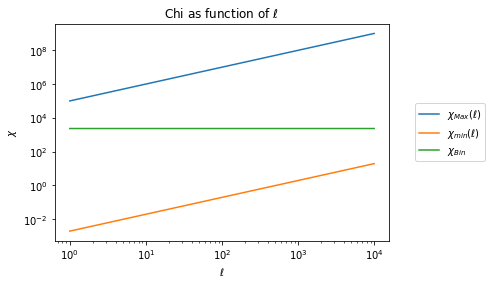

In [54]:
plt.loglog(ell_values,chiMax_values, label=r'$\chi_{Max}(\ell)$')
plt.loglog(ell_values,chimin_values, label=r'$\chi_{min}(\ell)$')
plt.loglog(ell_values,chiBin_value, label=r'$\chi_{Bin}$')

plt.legend(loc='right',bbox_to_anchor=(1.3, 0.5))


plt.title('Chi as function of $\ell$ ')
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\chi$")

plt.show()

#ell has been defined as the variable of the functions chiMax_func(ell) and chimin_func(ell)

In [55]:
DplusOfchi = CubicSpline(chi_y , DplusOfa(a_chi), extrapolate= True)
# now considering that the data from D+(chi) is actually stored in DplusOfchi_linG

In [56]:
def PddLinear(ell,chi):
    return DplusOfchi(chi)**2*pkl(ell/chi)

def power(ell,chi):
    return PddLinear(ell,chi)

# Defining (by hand 3000) the max value of chi, do not confuse this new variable with the one in background module
chiMax = chimax_lensEff # Note this is different from chi_Max
                        # where chi_Max is chi(z=20)=7519.607

q = CubicSpline(chiT, qT) # remeber this is equivalente to some kinda qT_lensEff.interpolate in Mathe

In [57]:
Nchi = 100

Ckappa_T = np.zeros((len(ell_T),2))
Ckappa_T.shape

(120, 2)

In [58]:
# runtime count
start_ck = time.time()
Ckappa_T = np.zeros((len(ell_T),2))

ones_vect = np.ones(Nchi) # this is a vector of dimension Nchi full of ones
m_Nchis = np.arange(Nchi)


for l in range(len(ell_T)):
    ell = ell_T[l] #choosing every particular value of ell
    chimin_ell = chimin_func(ell) #functions, not val.
    chiMax_eval = chiMax_func(ell)
    chiMax_ell = min(chiMax,chiMax_eval)
    #defining the max value as the min. between chi_Max (value) and chimax(ell) (evaluated function)
   
    
    delta_chi = (chiMax_ell - chimin_ell)/(Nchi-1)
    
    chi_Table = chimin_ell*ones_vect + delta_chi*m_Nchis
    
    #for m in range(Nchi):
    #    chi_Table[m] = chimin_ell + delta_chi*(m)

    
    pkappa, pkappa_B = 0, 0
    chi_A = chi_Table[0]
    pkappa_A = (q(chi_A)*q(chi_A)*power(ell,chi_A))/(chi_A**2)
    
    for n in range(1,len(chi_Table)):
        
        chi_B = chi_Table[n]
        pkappa_B = (q(chi_B)*q(chi_B)*power(ell,chi_B))/(chi_B**2)
        delta_chi = chi_B - chi_A
        
        pkappa = pkappa + (pkappa_A + pkappa_B)/2*delta_chi
        chi_A = chi_B
        pkappa_A = pkappa_B
    
    Ckappa_T[l] = [ell,pkappa]
        

# showing the time used to compute this calculation

end_ck = time.time()
print('The time used to compute this was ',end_ck - start_ck, 's')

Ckappa_T # showing array to make sure it is the same as in Mathematica

The time used to compute this was  0.3731832504272461 s


array([[1.00000000e+00, 2.02109380e-08],
       [1.10158194e+00, 2.13287022e-08],
       [1.21348277e+00, 2.24789445e-08],
       [1.33675070e+00, 2.36630856e-08],
       [1.47254043e+00, 2.48800228e-08],
       [1.62212394e+00, 2.61226267e-08],
       [1.78690243e+00, 2.73797602e-08],
       [1.96841945e+00, 2.86386159e-08],
       [2.16837531e+00, 2.98787585e-08],
       [2.38864308e+00, 3.10861752e-08],
       [2.63128607e+00, 3.22603377e-08],
       [2.89857721e+00, 3.34120709e-08],
       [3.19302031e+00, 3.45503424e-08],
       [3.51737350e+00, 3.56677669e-08],
       [3.87467512e+00, 3.67348988e-08],
       [4.26827213e+00, 3.77064809e-08],
       [4.70185149e+00, 3.85634452e-08],
       [5.17947468e+00, 3.93176870e-08],
       [5.70561576e+00, 3.99788222e-08],
       [6.28520327e+00, 4.05190349e-08],
       [6.92366640e+00, 4.09275640e-08],
       [7.62698586e+00, 4.11958978e-08],
       [8.40174987e+00, 4.12811244e-08],
       [9.25521591e+00, 4.11804861e-08],
       [1.019537

In [59]:
Ck_ell = np.zeros(len(Ckappa_T))
Ck_pkappa = np.zeros(len(Ckappa_T))

for i in range(len(Ckappa_T)):
    Ck_ell[i] = Ckappa_T[i][0]
    Ck_pkappa[i] = Ckappa_T[i][1]

print(Ck_ell)
print(Ck_pkappa)

[1.00000000e+00 1.10158194e+00 1.21348277e+00 1.33675070e+00
 1.47254043e+00 1.62212394e+00 1.78690243e+00 1.96841945e+00
 2.16837531e+00 2.38864308e+00 2.63128607e+00 2.89857721e+00
 3.19302031e+00 3.51737350e+00 3.87467512e+00 4.26827213e+00
 4.70185149e+00 5.17947468e+00 5.70561576e+00 6.28520327e+00
 6.92366640e+00 7.62698586e+00 8.40174987e+00 9.25521591e+00
 1.01953787e+01 1.12310450e+01 1.23719163e+01 1.36286796e+01
 1.50131073e+01 1.65381678e+01 1.82181470e+01 2.00687817e+01
 2.21074074e+01 2.43531207e+01 2.68269580e+01 2.95520924e+01
 3.25540512e+01 3.58609548e+01 3.95037801e+01 4.35166507e+01
 4.79371565e+01 5.28067057e+01 5.81709133e+01 6.40800274e+01
 7.05894009e+01 7.77600091e+01 8.56590215e+01 9.43604310e+01
 1.03945747e+02 1.14504757e+02 1.26136372e+02 1.38949549e+02
 1.53064314e+02 1.68612884e+02 1.85740907e+02 2.04608829e+02
 2.25393390e+02 2.48289288e+02 2.73510995e+02 3.01294772e+02
 3.31900880e+02 3.65616014e+02 4.02755998e+02 4.43668733e+02
 4.88737463e+02 5.383843

In [60]:
Ckappa_linear = CubicSpline(Ck_ell, Ck_pkappa)

def Ckappa_PS(l):
    return l*(l+1)/(2*math.pi)*Ckappa_linear(l)

Ckappa_PS_T = Ckappa_PS(ell_T) # Just to be able to plot it

## Plot of Convergence PS

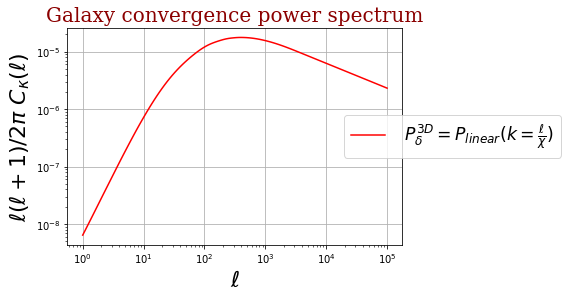

In [61]:
plt.loglog(ell_T, Ckappa_PS_T, 'r-', label=r' $P^{3D}_\delta = P_{linear}(k=\frac{\ell}{\chi})$')

font1 = {'family':'serif','color':'darkred','size':20}
font2 = {'family':'serif','color':'black','size':22}

plt.title(r'Galaxy convergence power spectrum', fontdict = font1)
plt.xlabel(r"$ \ell$", fontdict = font2)
plt.ylabel(r"$\ell (\ell +1)/2\pi \ C_\kappa (\ell)$ ", fontdict = font2)
plt.grid()

plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5),fontsize = 'xx-large')
plt.rcParams["figure.figsize"] = (10,6.8)

plt.show()

In [62]:
### OUTPUT ###

CkappaT_kappaPS = Ckappa_T

# Module **Correlation functions** $\normalsize{\xi_+}$ and $\normalsize{\xi_-}$ Using Method *FFTLog*

We need the next OUTPUTS:

xiPlusT_FFT_output

xiMinusT_FFT_output


The correlation functions are

$$
    \xi_+ (\theta) = \int_0^\infty \frac{\ell d\ell}{2\pi} J_0 (\ell \theta) C_\kappa (\ell),
$$

$$
    \xi_- (\theta) = \int_0^\infty \frac{\ell d\ell}{2\pi} J_4 (\ell \theta) C_\kappa (\ell).
$$


### Arcmin to radian relations

In [63]:
# defining conversion from rad to arcmin,
# where an arcmin is 1/60° and pi rad = 180°

def arcmin_to_rad(thethaArcMin):
    return thethaArcMin*math.pi/(180*60)

Nd = 60

# Using the values 3 arcmin and 200 arcmin as limits, then

interval = math.log10(arcmin_to_rad(200)/arcmin_to_rad(3))/(Nd-1)

tangle_T = np.zeros(Nd)
for i in range(Nd):
    tangle_T[i] = 10**(math.log10(arcmin_to_rad(3))+i*interval)

tangle_T

array([0.00087266, 0.00093705, 0.00100618, 0.00108041, 0.00116012,
       0.00124571, 0.00133761, 0.00143629, 0.00154226, 0.00165604,
       0.00177822, 0.00190941, 0.00205027, 0.00220153, 0.00236396,
       0.00253836, 0.00272563, 0.00292671, 0.00314264, 0.00337449,
       0.00362344, 0.00389077, 0.00417781, 0.00448603, 0.004817  ,
       0.00517238, 0.00555397, 0.00596372, 0.0064037 , 0.00687614,
       0.00738344, 0.00792816, 0.00851307, 0.00914113, 0.00981552,
       0.01053967, 0.01131725, 0.01215219, 0.01304873, 0.01401141,
       0.01504512, 0.01615509, 0.01734695, 0.01862674, 0.02000094,
       0.02147653, 0.02306099, 0.02476234, 0.0265892 , 0.02855085,
       0.03065722, 0.03291899, 0.03534762, 0.03795543, 0.04075563,
       0.04376242, 0.04699103, 0.05045784, 0.05418042, 0.05817764])

## FFTLog rutine

In [64]:
# Using the same PSL_.dat imported before but now proposing new min. and max. values of k

print(pkT)

N_fftlog =128 # even number chosen, usually takes one of the form 2^n 
kmin_fft = 1e-4
kMax_fft = 10
nu_bias = -1.3

print('k_min=', kmin_fft, ', k_Max=', kMax_fft)

              0          1
0      0.000010  46.913631
1      0.000010  47.384282
2      0.000010  48.304745
3      0.000011  49.242987
4      0.000011  50.199880
..          ...        ...
885  481.762566   0.000022
886  491.494940   0.000021
887  501.423924   0.000020
888  511.553489   0.000019
889  521.887688   0.000018

[890 rows x 2 columns]
k_min= 0.0001 , k_Max= 10


In [65]:
# This is a Module in Mathematica

int_fft = math.log(kMax_fft/kmin_fft)/(N_fftlog-1)

kT_fft = np.zeros(N_fftlog)
for i in range(N_fftlog):
    kT_fft[i] = kmin_fft*math.exp(i*int_fft)

Now defining an array to implement the **FFTlog method**, set as the indexed values $Pk_L(k_i)\left(\frac{k_i}{k_{min}}\right)^{-\nu_{bias}}$,

In [66]:
toFFT_T = np.zeros(N_fftlog)
for i in range(N_fftlog):
    toFFT_T[i] = pkl(kT_fft[i])*(kT_fft[i]/kmin_fft)**(-nu_bias)

# defining an array for values of eta as an complex number

etam_fft_T = np.zeros(N_fftlog+1, dtype=np.complex_) # require to specify that this array is for complex variables
for i in range(N_fftlog+1): # + 1 ???
    etam_fft_T[i] = nu_bias + 2*math.pi*1j*(i - N_fftlog/2)*(N_fftlog-1)/(math.log(kMax_fft/kmin_fft)*(N_fftlog))

# Using the Discrete Fourier Transform from numpy

pre_cm_T = np.fft.fft(toFFT_T, norm = "forward")    # parameters a=0, b=-1 are already in the definition

# for a=-1, i.e., 1/n we make: norm = "forward"

In [67]:
cm_T = np.zeros(N_fftlog+1, dtype=np.complex_)

for i in range(N_fftlog+1):
    if i-N_fftlog/2 < 0: # from i=0 to 63    ---> give the 'pre_cm' from 64 to 1
        cm_T[i] = kmin_fft**(-etam_fft_T[i])*np.conj(pre_cm_T[-i + N_fftlog//2])
    else:   # from i=64 to 128 (129 is no longer considered) ---> give the 'pre_cm' from 0 to 64
        cm_T[i] = kmin_fft**(-etam_fft_T[i])*pre_cm_T[i - N_fftlog//2]

cm_T

array([-1.73324412e-02-5.33437688e-02j, -7.70001769e-03-3.15361266e-02j,
        2.11278215e-02+3.34859525e-03j,  4.61887454e-02+1.16506397e-02j,
        4.08817745e-02+1.49323368e-03j,  6.79777518e-03+8.70300446e-03j,
       -2.54514075e-02+3.62161426e-02j, -3.10161930e-02+4.56453570e-02j,
       -1.95617704e-02+1.28106510e-02j, -1.72078499e-02-3.62452435e-02j,
       -2.28593815e-02-5.71792820e-02j, -6.81525788e-03-3.80471102e-02j,
        3.91511785e-02-4.76395081e-03j,  7.39398797e-02+1.81439547e-02j,
        5.06748903e-02+3.19838961e-02j, -1.91269200e-02+4.59021978e-02j,
       -7.36901053e-02+5.02533298e-02j, -7.36234606e-02+2.12288421e-02j,
       -3.75794049e-02-4.43834500e-02j,  1.93138555e-03-1.04695286e-01j,
        4.18028211e-02-9.89904796e-02j,  8.46624438e-02-1.34445439e-02j,
        1.00150306e-01+9.05328899e-02j,  4.68575765e-02+1.33080541e-01j,
       -6.72707865e-02+9.20405015e-02j, -1.64500485e-01+2.77099723e-03j,
       -1.50161064e-01-9.23596632e-02j, -3.70396633

In [68]:
# Handly giving the first and last terms the right values (half)

cm_T[0] = cm_T[0]/2
cm_T[-1] = cm_T[-1]/2

result = np.concatenate((cm_T.reshape(-1,1),etam_fft_T.reshape(-1,1)), axis = 1)
result   #3era cifr

array([[-8.66622058e-03-2.66718844e-02j, -1.30000000e+00-3.46551594e+01j],
       [-7.70001769e-03-3.15361266e-02j, -1.30000000e+00-3.41136725e+01j],
       [ 2.11278215e-02+3.34859525e-03j, -1.30000000e+00-3.35721857e+01j],
       [ 4.61887454e-02+1.16506397e-02j, -1.30000000e+00-3.30306988e+01j],
       [ 4.08817745e-02+1.49323368e-03j, -1.30000000e+00-3.24892119e+01j],
       [ 6.79777518e-03+8.70300446e-03j, -1.30000000e+00-3.19477251e+01j],
       [-2.54514075e-02+3.62161426e-02j, -1.30000000e+00-3.14062382e+01j],
       [-3.10161930e-02+4.56453570e-02j, -1.30000000e+00-3.08647513e+01j],
       [-1.95617704e-02+1.28106510e-02j, -1.30000000e+00-3.03232645e+01j],
       [-1.72078499e-02-3.62452435e-02j, -1.30000000e+00-2.97817776e+01j],
       [-2.28593815e-02-5.71792820e-02j, -1.30000000e+00-2.92402907e+01j],
       [-6.81525788e-03-3.80471102e-02j, -1.30000000e+00-2.86988039e+01j],
       [ 3.91511785e-02-4.76395081e-03j, -1.30000000e+00-2.81573170e+01j],
       [ 7.39398797e-02+1

#### We define cmT_etamT which is the array returned by introduce the variables k, nu and N given

(this is not necessary here bc in mathematica is defined through a module)

All we need is the variable outputted as 'result' and we already have it as cm

In [69]:
# Recalling the fisrt min. & max. value of chi in this code

chiMax_backg = chiOfzT_backg[-1][1] # same chi_Max (7519.61)
chimin_backg = chiOfzT_backg[0][1]  # same chi_min (0.0)

Nchi_fft = 150
chimin_fft = max(0.0001, chimin_backg)
chiMax_fft = min(chimax_lensEff, chiMax_backg)
deltachi_fft = math.log10(chiMax_fft/chimin_fft)/(Nchi_fft-1)

In [70]:
chiT_fft = np.zeros(Nchi_fft)
for i in range(Nchi_fft):
    chiT_fft[i] = 10**(math.log10(chimin_fft) + deltachi_fft*i)

print('chiT_fft: ', Nchi_fft, 'log-spaced chi values over the interval [', chimin_fft,',', chiMax_fft,'] Mpc/h.')

chiT_fft

chiT_fft:  150 log-spaced chi values over the interval [ 0.0001 , 3000 ] Mpc/h.


array([1.00000000e-04, 1.12248881e-04, 1.25998114e-04, 1.41431473e-04,
       1.58755247e-04, 1.78200989e-04, 2.00028616e-04, 2.24529884e-04,
       2.52032284e-04, 2.82903419e-04, 3.17555924e-04, 3.56452972e-04,
       4.00114474e-04, 4.49124021e-04, 5.04136690e-04, 5.65887796e-04,
       6.35202721e-04, 7.13007949e-04, 8.00343447e-04, 8.98376566e-04,
       1.00841765e-03, 1.13193753e-03, 1.27058721e-03, 1.42621993e-03,
       1.60091592e-03, 1.79701022e-03, 2.01712387e-03, 2.26419898e-03,
       2.54153802e-03, 2.85284800e-03, 3.20228997e-03, 3.59453467e-03,
       4.03482496e-03, 4.52904589e-03, 5.08380335e-03, 5.70651239e-03,
       6.40549633e-03, 7.19009797e-03, 8.07080455e-03, 9.05938783e-03,
       1.01690615e-02, 1.14146578e-02, 1.28128257e-02, 1.43822535e-02,
       1.61439187e-02, 1.81213681e-02, 2.03410330e-02, 2.28325820e-02,
       2.56293179e-02, 2.87686227e-02, 3.22924572e-02, 3.62479219e-02,
       4.06878869e-02, 4.56716979e-02, 5.12659701e-02, 5.75454779e-02,
      

In [71]:
Am_T = np.zeros(len(etam_fft_T),dtype=np.complex_)

start_am = time.time()

for j in range(len(etam_fft_T)):
    etam = etam_fft_T[j]
    am = 1 + etam
    
    Am = 0
    Am_B = 0
    chifft_A = chiT_fft[0]
    Am_A = q(chifft_A)*q(chifft_A)*DplusOfchi(chifft_A)*DplusOfchi(chifft_A)*chifft_A**(-am-1)
    
    for k in range(len(chiT_fft)):
        chifft_B = chiT_fft[k]
        Am_B = q(chifft_B)*q(chifft_B)*DplusOfchi(chifft_B)*DplusOfchi(chifft_B)*chifft_B**(-am-1)
        deltachi_am = chifft_B - chifft_A
        Am = Am + (Am_A + Am_B)/2*deltachi_am
        chifft_A = chifft_B
        Am_A = Am_B
        
    Am_T[j] = Am

end_am = time.time()
print("The time used to execute this is",end_am - start_am, 's.')

Am_T         # 4ta cifr. (3era imag)

The time used to execute this is 0.7349197864532471 s.


array([-2.14386642e-11-3.92559402e-11j,  4.06820075e-11+2.37224839e-12j,
       -2.15809717e-11+3.02510461e-11j, -1.27592896e-11-3.14240612e-11j,
        3.04598368e-11+5.68747436e-12j, -1.95432352e-11+2.05334224e-11j,
       -5.85025045e-12-2.53130694e-11j,  2.23116967e-11+8.49660932e-12j,
       -1.80940666e-11+1.25602269e-11j,  7.12882917e-14-2.04371904e-11j,
        1.55085903e-11+1.11778742e-11j, -1.71921264e-11+5.59479444e-12j,
        5.56175026e-12-1.64257594e-11j,  9.50098845e-12+1.40003705e-11j,
       -1.67988177e-11-9.28081172e-13j,  1.10635987e-11-1.29841158e-11j,
        3.83686157e-12+1.71924369e-11j, -1.68921618e-11-7.49842454e-12j,
        1.69876556e-11-9.85720352e-12j, -1.90865422e-12+2.09888459e-11j,
       -1.74689063e-11-1.46123483e-11j,  2.37815575e-11-6.78857207e-12j,
       -8.20491736e-12+2.56668058e-11j, -1.85363003e-11-2.28541437e-11j,
        3.19980161e-11-3.46691140e-12j, -1.56531613e-11+3.15772861e-11j,
       -2.00907948e-11-3.29949768e-11j,  4.23756324

In [72]:
am_T = 1 + etam_fft_T
am_T

array([-0.3-34.65515939j, -0.3-34.11367252j, -0.3-33.57218566j,
       -0.3-33.03069879j, -0.3-32.48921193j, -0.3-31.94772506j,
       -0.3-31.40623819j, -0.3-30.86475133j, -0.3-30.32326446j,
       -0.3-29.7817776j , -0.3-29.24029073j, -0.3-28.69880387j,
       -0.3-28.157317j  , -0.3-27.61583014j, -0.3-27.07434327j,
       -0.3-26.53285641j, -0.3-25.99136954j, -0.3-25.44988268j,
       -0.3-24.90839581j, -0.3-24.36690894j, -0.3-23.82542208j,
       -0.3-23.28393521j, -0.3-22.74244835j, -0.3-22.20096148j,
       -0.3-21.65947462j, -0.3-21.11798775j, -0.3-20.57650089j,
       -0.3-20.03501402j, -0.3-19.49352716j, -0.3-18.95204029j,
       -0.3-18.41055342j, -0.3-17.86906656j, -0.3-17.32757969j,
       -0.3-16.78609283j, -0.3-16.24460596j, -0.3-15.7031191j ,
       -0.3-15.16163223j, -0.3-14.62014537j, -0.3-14.0786585j ,
       -0.3-13.53717164j, -0.3-12.99568477j, -0.3-12.4541979j ,
       -0.3-11.91271104j, -0.3-11.37122417j, -0.3-10.82973731j,
       -0.3-10.28825044j, -0.3 -9.746763

In [73]:
from scipy.special import gamma

Im0_T = np.zeros(len(etam_fft_T), dtype=np.complex_)
for i in range(len(etam_fft_T)):
    Im0_T[i] = (2**(-1 + am_T[i])*gamma(1/2*(1+am_T[i])))/(math.pi*gamma(1/2*(1-am_T[i])))
    
Im0_T  # this coincide with mathem.nb

array([ 0.05320999-0.0136874j , -0.00512275+0.05496427j,
       -0.05044075-0.02307484j,  0.03825519-0.04053924j,
        0.02665313+0.04926942j, -0.05532451+0.01043436j,
        0.0064302 -0.05622293j,  0.05228759+0.02240479j,
       -0.03623789+0.04424186j, -0.03306861-0.04703781j,
        0.05429448-0.01986983j,  0.00574258+0.05785705j,
       -0.05787994-0.00831858j,  0.02148817-0.05475062j,
        0.04901112+0.03314585j, -0.04288563+0.04128281j,
       -0.03220145-0.05050391j,  0.0559729 -0.02236604j,
        0.01230311+0.05940578j, -0.06101896+0.00244563j,
        0.00687518-0.06109565j,  0.05995378+0.01542791j,
       -0.02307157+0.05791979j, -0.05530897-0.02974156j,
        0.03543313-0.05241217j,  0.04948809+0.04018429j,
       -0.04405921+0.04676015j, -0.04441664-0.04713296j,
        0.04947799-0.04261291j,  0.04147444+0.05115219j,
       -0.05218866+0.04109954j, -0.04156061-0.05258681j,
        0.05230484-0.04290293j,  0.04513991+0.05125381j,
       -0.04929384+0.04824381j,

In [74]:
Im4_T = np.zeros(len(etam_fft_T),dtype=np.complex_)
for i in range(len(etam_fft_T)):
    Im4_T[i] = (2**(-1 + am_T[i])*gamma(1/2*(5+am_T[i])))/(math.pi*gamma(1/2*(5-am_T[i])))
    
Im4_T # This is correct too 

array([ 0.05482063-0.00117296j, -0.01769267+0.05217102j,
       -0.04349411-0.03423429j,  0.04674305-0.0301401j ,
        0.01383876+0.0541499j , -0.0560557 -0.00355896j,
        0.02030783-0.05267372j,  0.04470962+0.03494099j,
       -0.0463779 +0.0332072j , -0.01938614-0.05396817j,
        0.05748006-0.0044926j , -0.01032263+0.05704719j,
       -0.05308903-0.02409116j,  0.03607753-0.04621988j,
        0.0371588 +0.04579661j, -0.05300384+0.02664961j,
       -0.01539673-0.05766611j,  0.0599209 -0.0040191j ,
       -0.00697778+0.06003064j, -0.05833785-0.01721377j,
        0.02643304-0.05522501j,  0.05108158+0.03449346j,
       -0.0413499 +0.04627916j, -0.04115481-0.04703447j,
        0.05163596-0.03600176j,  0.03106616+0.0552803j ,
       -0.05811299+0.0265487j , -0.02260944-0.06028404j,
        0.06193548-0.01937463j,  0.01694428+0.06319098j,
       -0.06414737+0.01539959j, -0.01480909-0.06486719j,
        0.06537192-0.01523285j,  0.01672391+0.06563531j,
       -0.06557682+0.01932579j,

In [75]:
xiPlus_product = np.zeros(len(cm_T), dtype=np.complex_)

def xiPlusf_T(theta):           # 'f' stands for 'function'
    for i in range(len(cm_T)):
        xiPlus_product[i] = cm_T[i]*Am_T[i]*Im0_T[i]*theta**(-am_T[i]-1)
        
    return np.sum(xiPlus_product)

In [76]:
# creating array (x,y) where x= t. angle, y=xi_+(t.ang)

# first the y column

real_xiP_oftangle = np.zeros(len(tangle_T))

for i in range(len(tangle_T)):
    real_xiP_oftangle[i] = np.real(xiPlusf_T(tangle_T[i]))

# now putting them togheter (x is already known)
xiPlus_T = np.concatenate((tangle_T.reshape(-1,1),real_xiP_oftangle.reshape(-1,1)), axis = 1)
xiPlus_T      # x and y are correct now (CORRECTION 26/sept)

array([[8.72664626e-04, 5.27330234e-05],
       [9.37046363e-04, 5.17121368e-05],
       [1.00617793e-03, 5.06698313e-05],
       [1.08040975e-03, 4.96065226e-05],
       [1.16011810e-03, 4.85221310e-05],
       [1.24570701e-03, 4.74177260e-05],
       [1.33761034e-03, 4.62947427e-05],
       [1.43629393e-03, 4.51534257e-05],
       [1.54225800e-03, 4.39950991e-05],
       [1.65603968e-03, 4.28212992e-05],
       [1.77821573e-03, 4.16328850e-05],
       [1.90940543e-03, 4.04315283e-05],
       [2.05027380e-03, 3.92187290e-05],
       [2.20153487e-03, 3.79958894e-05],
       [2.36395539e-03, 3.67648591e-05],
       [2.53835865e-03, 3.55272573e-05],
       [2.72562869e-03, 3.42849180e-05],
       [2.92671477e-03, 3.30397979e-05],
       [3.14263618e-03, 3.17937902e-05],
       [3.37448742e-03, 3.05490005e-05],
       [3.62344373e-03, 2.93074989e-05],
       [3.89076705e-03, 2.80714201e-05],
       [4.17781242e-03, 2.68429693e-05],
       [4.48603486e-03, 2.56243212e-05],
       [4.816996

In [77]:
xiPlusf_T(1) # no está dando igual a mathe

# PARTE IMAGINARIA de xiPlusf_T (func(θ)) DIFIERE
# sin embargo, parte imaginaria es 16 órdenes menor que real.

(2.0025556484211097e-08-1.6543612251060553e-24j)

In [78]:
# interpolating
xiPlus = CubicSpline(tangle_T,real_xiP_oftangle, extrapolate = True)

In [79]:
# Now doing the same for the minus component (with Im4T)
xiMinus_product = np.zeros(len(cm_T), dtype=np.complex_)

def xiMinusf_T(theta):
    for i in range(len(cm_T)):
        xiMinus_product[i] = cm_T[i]*Am_T[i]*Im4_T[i]*theta**(-am_T[i] - 1)
    return np.sum(xiMinus_product)


real_xiM_oftangle = np.zeros(len(tangle_T))

for i in range(len(tangle_T)):
    real_xiM_oftangle[i] = np.real(xiMinusf_T(tangle_T[i]))

xiMinus_T = np.concatenate((tangle_T.reshape(-1,1),real_xiM_oftangle.reshape(-1,1)), axis = 1)
print(xiMinus_T)

# interpolating
xiMinus = CubicSpline(tangle_T,real_xiM_oftangle, extrapolate = True)

[[8.72664626e-04 2.18107170e-06]
 [9.37046363e-04 2.25894709e-06]
 [1.00617793e-03 2.33734167e-06]
 [1.08040975e-03 2.41626370e-06]
 [1.16011810e-03 2.49530330e-06]
 [1.24570701e-03 2.57512334e-06]
 [1.33761034e-03 2.65616527e-06]
 [1.43629393e-03 2.73766245e-06]
 [1.54225800e-03 2.81994572e-06]
 [1.65603968e-03 2.90310949e-06]
 [1.77821573e-03 2.98655619e-06]
 [1.90940543e-03 3.07040937e-06]
 [2.05027380e-03 3.15436276e-06]
 [2.20153487e-03 3.23801554e-06]
 [2.36395539e-03 3.32126720e-06]
 [2.53835865e-03 3.40367321e-06]
 [2.72562869e-03 3.48496706e-06]
 [2.92671477e-03 3.56486892e-06]
 [3.14263618e-03 3.64298172e-06]
 [3.37448742e-03 3.71904355e-06]
 [3.62344373e-03 3.79267386e-06]
 [3.89076705e-03 3.86352338e-06]
 [4.17781242e-03 3.93125346e-06]
 [4.48603486e-03 3.99547182e-06]
 [4.81699673e-03 4.05583509e-06]
 [5.17237565e-03 4.11196156e-06]
 [5.55397303e-03 4.16348534e-06]
 [5.96372314e-03 4.21004650e-06]
 [6.40370300e-03 4.25128433e-06]
 [6.87614282e-03 4.28686310e-06]
 [7.383437

In [80]:
xiPlus(0)

array(7.36820945e-05)

In [81]:
def xiP_plot(t):
    return (10**4)*t*xiPlus(t*math.pi/(180*60))

def xiM_plot(t):
    return (10**4)*t*xiMinus(t*math.pi/(180*60))

t_xiplot = np.linspace(3,200, num=1000, endpoint=True)

xi_P = xiP_plot(t_xiplot)
xi_M = xiM_plot(t_xiplot)

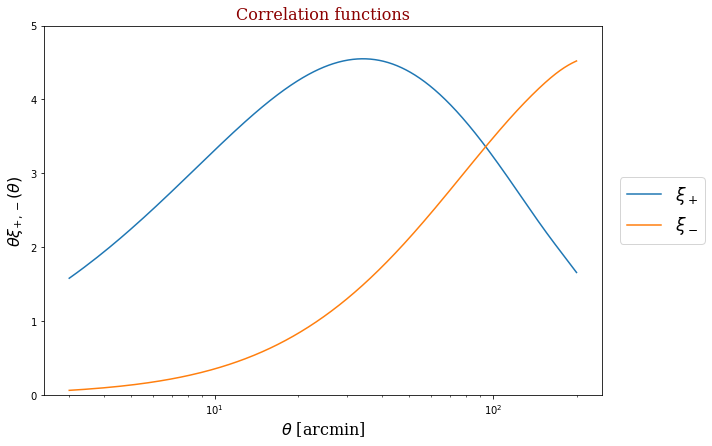

In [82]:
plt.plot(t_xiplot,xi_P, "-", label=r'$\xi_+$')
plt.plot(t_xiplot,xi_M, "-", label=r'$\xi_-$')

font1 = {'family':'serif','color':'darkred','size':16}
font2 = {'family':'serif','color':'black','size':16}

plt.legend(loc='right',bbox_to_anchor=(1.2, 0.5),fontsize = 'xx-large')

plt.title(r'Correlation functions', fontdict = font1)
plt.xlabel(r"$\theta$ [arcmin]",fontdict = font2)
plt.ylabel(r"$\theta \xi_{+,-}(\theta)$",fontdict = font2)

plt.ylim(0,5)
plt.xscale('log')

plt.show()         # A PESAR DE QUE SE PARECEN NO TIENE LOS MISMOS VALORES EN LA PTE. IMAG.

In [83]:
# Save output variables

xiPlus_FFT_output = xiPlus_T
xiMinus_FFT_output = xiMinus_T

## Module Correlation functions $\xi_+$ and $\xi_-$ Using Direct integration of Ckappa

Recalling the same **PSL data 'pkT'** with its own **kmin=0.00001** and **kMax=521.8876**, and the outputted **Ckappa** (*Ckappa_linear* is the interpolated function), we proceed straightforward.

(Recall max. and min. values of ell in Ckappa are **ellmin = 1, ellMax = 100 000** and we are using a log10 interval of Nd=60 steps).

In [84]:
# Defining from Bessel Functions
import scipy 
def intPlus(theta, ell1):
    return 1/(2*math.pi)*ell1*scipy.special.jv(0,ell1*theta)*Ckappa_linear(ell1)

def intMinus(theta, ell1):
    return 1/(2*math.pi)*ell1*scipy.special.jv(4,ell1*theta)*Ckappa_linear(ell1)

In [85]:
# This is a parallel table in Mathem.

xiPlus_y_direct = np.zeros(len(tangle_T))

import scipy.integrate
from scipy.integrate import quad

for i in range(len(tangle_T)):
    xiPlus_y_direct[i] = quad(lambda ell: intPlus(tangle_T[i],ell), ellmin, ellMax)[0]

xiPlus_y_direct

<ipython-input-85-52073a5fe02c>:9: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  xiPlus_y_direct[i] = quad(lambda ell: intPlus(tangle_T[i],ell), ellmin, ellMax)[0]
<ipython-input-85-52073a5fe02c>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xiPlus_y_direct[i] = quad(lambda ell: intPlus(tangle_T[i],ell), ellmin, ellMax)[0]


array([5.25513551e-05, 5.15351297e-05, 5.04975567e-05, 4.94397461e-05,
       4.83599518e-05, 4.72570949e-05, 4.61399848e-05, 4.50004574e-05,
       4.38476101e-05, 4.26778883e-05, 4.14932003e-05, 4.02956856e-05,
       3.90859459e-05, 3.78667107e-05, 3.66397795e-05, 3.54064395e-05,
       3.41678629e-05, 3.29267352e-05, 3.16836496e-05, 3.04426526e-05,
       2.92049254e-05, 2.79725803e-05, 2.67483014e-05, 2.55328563e-05,
       2.43295188e-05, 2.31407935e-05, 2.19682573e-05, 2.08140298e-05,
       1.96807975e-05, 1.85710915e-05, 1.74899744e-05, 1.64264116e-05,
       1.53960711e-05, 1.43807479e-05, 1.34114377e-05, 1.24731536e-05,
       1.15703037e-05, 1.07237541e-05, 9.21454607e-06, 8.03997885e-06,
       8.36022604e-06, 7.64201714e-06, 6.96481908e-06, 6.33145703e-06,
       5.76111538e-06, 5.17813540e-06, 4.65112621e-06, 4.18719352e-06,
       3.38956830e-06, 3.75768954e-06, 2.92495333e-06, 2.57864360e-06,
       2.25988980e-06, 1.97423080e-06, 1.71822792e-06, 1.49108010e-06,
      

In [86]:
xiPlus_T_direct = np.concatenate((tangle_T.reshape(-1,1),xiPlus_y_direct.reshape(-1,1)), axis = 1)
xiPlus_T_direct

array([[8.72664626e-04, 5.25513551e-05],
       [9.37046363e-04, 5.15351297e-05],
       [1.00617793e-03, 5.04975567e-05],
       [1.08040975e-03, 4.94397461e-05],
       [1.16011810e-03, 4.83599518e-05],
       [1.24570701e-03, 4.72570949e-05],
       [1.33761034e-03, 4.61399848e-05],
       [1.43629393e-03, 4.50004574e-05],
       [1.54225800e-03, 4.38476101e-05],
       [1.65603968e-03, 4.26778883e-05],
       [1.77821573e-03, 4.14932003e-05],
       [1.90940543e-03, 4.02956856e-05],
       [2.05027380e-03, 3.90859459e-05],
       [2.20153487e-03, 3.78667107e-05],
       [2.36395539e-03, 3.66397795e-05],
       [2.53835865e-03, 3.54064395e-05],
       [2.72562869e-03, 3.41678629e-05],
       [2.92671477e-03, 3.29267352e-05],
       [3.14263618e-03, 3.16836496e-05],
       [3.37448742e-03, 3.04426526e-05],
       [3.62344373e-03, 2.92049254e-05],
       [3.89076705e-03, 2.79725803e-05],
       [4.17781242e-03, 2.67483014e-05],
       [4.48603486e-03, 2.55328563e-05],
       [4.816996

In [87]:
# similarly with xiMinus

xiMinus_y_direct = np.zeros(len(tangle_T))

for i in range(len(tangle_T)):
    xiMinus_y_direct[i] = quad(lambda ell: intMinus(tangle_T[i],ell), ellmin, ellMax)[0]

xiMinus_T_direct = np.concatenate((tangle_T.reshape(-1,1),xiMinus_y_direct.reshape(-1,1)), axis = 1)
xiMinus_T_direct

<ipython-input-87-ba51bbb24026>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  xiMinus_y_direct[i] = quad(lambda ell: intMinus(tangle_T[i],ell), ellmin, ellMax)[0]


array([[8.72664626e-04, 2.22360759e-06],
       [9.37046363e-04, 2.29227502e-06],
       [1.00617793e-03, 2.36328755e-06],
       [1.08040975e-03, 2.43716127e-06],
       [1.16011810e-03, 2.51134436e-06],
       [1.24570701e-03, 2.58428362e-06],
       [1.33761034e-03, 2.66364750e-06],
       [1.43629393e-03, 2.74000082e-06],
       [1.54225800e-03, 2.82127086e-06],
       [1.65603968e-03, 2.90256802e-06],
       [1.77821573e-03, 2.98413178e-06],
       [1.90940543e-03, 3.06644018e-06],
       [2.05027380e-03, 3.14833476e-06],
       [2.20153487e-03, 3.23071875e-06],
       [2.36395539e-03, 3.31328111e-06],
       [2.53835865e-03, 3.39536829e-06],
       [2.72562869e-03, 3.47596399e-06],
       [2.92671477e-03, 3.55495109e-06],
       [3.14263618e-03, 3.63227831e-06],
       [3.37448742e-03, 3.70794522e-06],
       [3.62344373e-03, 3.78127351e-06],
       [3.89076705e-03, 3.85168675e-06],
       [4.17781242e-03, 3.91950902e-06],
       [4.48603486e-03, 3.98351731e-06],
       [4.816996

In [88]:
integrand_intMinus = intMinus(0.05, ell_T)
integrand_intMinus2 = intMinus(0.01, ell_T)

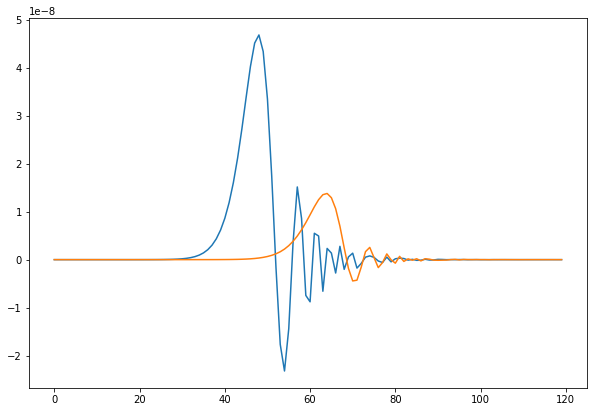

In [89]:
plt.plot(integrand_intMinus)
plt.plot(integrand_intMinus2)
plt.show()

In [90]:
xiPlus_direct = CubicSpline(tangle_T,xiPlus_T_direct, extrapolate=True)
xiMinus_direct = CubicSpline(tangle_T,xiMinus_T_direct, extrapolate=True)

In [91]:
# NOTE the difference between the shape of case FFT and Direct with

print(xiPlus_direct(0.001))    # gives a pair (array)
print(xiPlus_direct(0.001)[1]) # gives the second value (the desired one)

[1.00000000e-03 5.05881341e-05]
5.058813411902675e-05


In [92]:
# But since this case involves an array of different shape (direct method returns (1000,2) instead of just
# (1000,) as the FFT case) we have put an index [:,1] right next to function evaluation of 'xi_direct'

def xiP_plot_direct(t):
    return (10**4)*t*xiPlus_direct(t*math.pi/(180*60))[:,1] # we specify we want the value from its second column (all the rows)

def xiM_plot_direct(t):
    return (10**4)*t*xiMinus_direct(t*math.pi/(180*60))[:,1]

In [93]:
xiP_plot_direct # is a function, so it should return a float

<function __main__.xiP_plot_direct(t)>

In [94]:
xi_P_direct = xiP_plot_direct(t_xiplot)
xi_M_direct = xiM_plot_direct(t_xiplot)

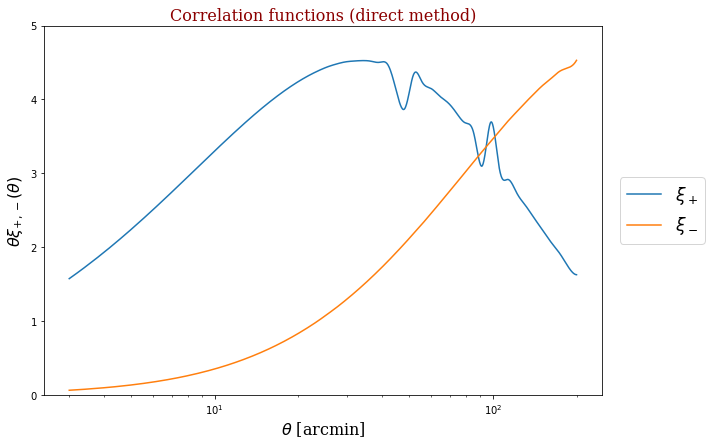

In [95]:
# P L O T S (direct method)

plt.plot(t_xiplot,xi_P_direct, "-", label=r'$\xi_+$')
plt.plot(t_xiplot,xi_M_direct, "-", label=r'$\xi_-$')

font1 = {'family':'serif','color':'darkred','size':16}
font2 = {'family':'serif','color':'black','size':16}

plt.legend(loc='right',bbox_to_anchor=(1.2, 0.5),fontsize = 'xx-large')

plt.title(r'Correlation functions (direct method)', fontdict = font1)
plt.xlabel(r"$\theta$ [arcmin]",fontdict = font2)
plt.ylabel(r"$\theta \xi_{+,-}(\theta)$",fontdict = font2)

plt.ylim(0,5)
plt.xscale('log')

plt.show()

In [96]:
# STORE OUTPUT VARIABLES

xiPlusT_directIntegration = xiPlus_T_direct
xiMinusT_directIntegration = xiMinus_T_direct

# Comparing methods

In [97]:
xiPlusDirect = CubicSpline(xiPlusT_directIntegration[:,0], xiPlusT_directIntegration[:,1])
xiMinusDirect = CubicSpline(xiMinusT_directIntegration[:,0], xiMinusT_directIntegration[:,1])

xiPlusFFT = CubicSpline(xiPlus_FFT_output[:,0], xiPlus_FFT_output[:,1])
xiMinusFFT = CubicSpline(xiMinus_FFT_output[:,0], xiMinus_FFT_output[:,1])

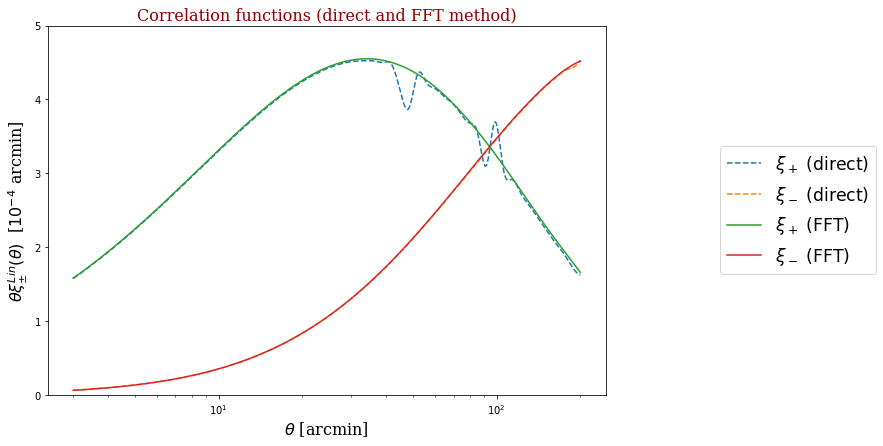

In [98]:
# JUST IN ORDER TO PLOT
def xiP_plot_dir(t):
    return (10**4)*t*xiPlusDirect(t*math.pi/(180*60))

def xiM_plot_dir(t):
    return (10**4)*t*xiMinusDirect(t*math.pi/(180*60))

xi_P_dir = xiP_plot_dir(t_xiplot)
xi_M_dir = xiM_plot_dir(t_xiplot)


def xiP_plot_FFT(t):
    return (10**4)*t*xiPlusFFT(t*math.pi/(180*60))

def xiM_plot_FFT(t):
    return (10**4)*t*xiMinusFFT(t*math.pi/(180*60))

xi_P_FFT = xiP_plot_FFT(t_xiplot)
xi_M_FFT = xiM_plot_FFT(t_xiplot)


### PLOTTING COMPARATION ###

plt.plot(t_xiplot,xi_P_dir, "--", label=r'$\xi_+$ (direct)')
plt.plot(t_xiplot,xi_M_dir, "--", label=r'$\xi_-$ (direct)')
plt.plot(t_xiplot,xi_P_FFT, "-", label=r'$\xi_+$ (FFT)')
plt.plot(t_xiplot,xi_M_FFT, "-", label=r'$\xi_-$ (FFT)')

font1 = {'family':'serif','color':'darkred','size':16}
font2 = {'family':'serif','color':'black','size':16}

plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5),fontsize = 'xx-large')

plt.title(r'Correlation functions (direct and FFT method)', fontdict = font1)
plt.xlabel(r"$\theta$ [arcmin]",fontdict = font2)
plt.ylabel(r"$\theta \xi_{\pm}^{Lin}(\theta)$  [$10^{-4}$ arcmin]",fontdict = font2)

plt.ylim(0,5)
plt.xscale('log')

plt.show()

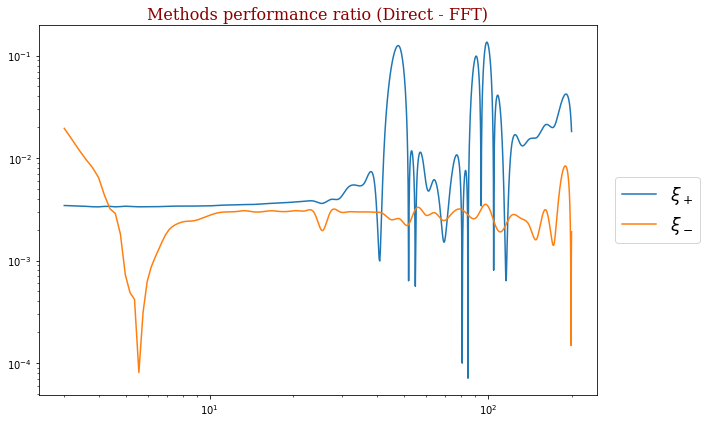

In [99]:
plt.loglog(t_xiplot, np.abs((xi_P_dir)/(xi_P_FFT) - 1), label=r'$\xi_+$')
plt.loglog(t_xiplot, np.abs((xi_M_dir)/(xi_M_FFT) - 1), label=r'$\xi_-$')

font1 = {'family':'serif','color':'darkred','size':16}
font2 = {'family':'serif','color':'black','size':16}

plt.legend(loc='right',bbox_to_anchor=(1.2, 0.5),fontsize = 'xx-large')

plt.title(r'Methods performance ratio (Direct - FFT)', fontdict = font1)
plt.show()